In [4]:
import pandas as pd 
import numpy as np 
import os
import glob
import subprocess
from tqdm import tqdm
import itertools
import networkx as nx
import seaborn as sns
import matplotlib as mpl
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import math
import re
from utils import * 
from src.data import * 
import json
import sklearn
import io 
import itertools
from src.files import *
from Bio.Seq import Seq
from src.coev import * 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def write_fasta(df:pd.DataFrame, protein:str='virc1', path:str='../data/data-1/virc1.fa'):
    '''Remove duplicate VirC proteins and write sequences to a FASTA file.'''
    df = df.copy().drop_duplicates(f'{protein}_variant')
    df['id'] = [f'{protein}_{variant}' for variant in df[f'{protein}_variant']]
    df = df.set_index('id')
    df['seq'] = df[f'{protein}_seq']
    df = df[~df.seq.isnull()].copy()
    FASTAFile(df=df).write(path)
    print(f'write_fasta: {len(df)} sequences written to {path}')

In [6]:
# I am going to rethink my approach to this analysis, and start with a protein-centric view of things. 

hmmer_df = load_hmmer_files(hmmer_dir='../data/data-1/hmmer')
overdrive_df = build_overdrive_dataset(overwrite=False, fasta_dir='../data/data-1/ncbi/fasta/', hmmer_df=hmmer_df, length=200, data_dir='../data/data-1/')

print(f'Loaded {overdrive_df.variant.nunique()} different right border adjacent regions from {overdrive_df.source_id.nunique()} plasmids.')
print(f'Removing {(overdrive_df.virc1_seq.isnull() | overdrive_df.virc2_seq.isnull()).sum()} entries with no associated VirC1 and VirC2.')
overdrive_df = overdrive_df[~overdrive_df.virc1_seq.isnull() & ~overdrive_df.virc2_seq.isnull()].copy()
for col in [col for col in overdrive_df.columns if ('variant' in col)]:
    overdrive_df[col] = overdrive_df[col].astype(int)

write_fasta(overdrive_df, protein='virc1', path='../data/data-1/virc1.fa')
write_fasta(overdrive_df, protein='virc2', path='../data/data-1/virc2.fa')

load_hmmer: Num. hits for query T-DNA_left_border: 296
load_hmmer: Num. hits for query T-DNA_right_border: 426
load_hmmer: Num. hits for query overdrive: 43
build_overdrive_dataset: Found 193 right borders.
Loaded 27 different right border adjacent regions from 137 plasmids.
Removing 3 entries with no associated VirC1 and VirC2.
write_fasta: 10 sequences written to ../data/data-1/virc1.fa
write_fasta: 12 sequences written to ../data/data-1/virc2.fa


In [7]:

# ! /home/prichter/muscle5.1.linux_intel64 -align ../data/data-1/virc1.fa -output ../data/data-1/virc1.afa
# ! /home/prichter/muscle5.1.linux_intel64 -align ../data/data-1/virc2.fa -output ../data/data-1/virc2.afa

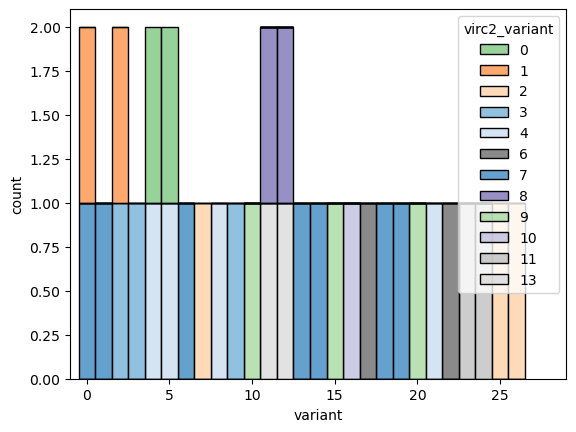

In [8]:
def figure(overdrive_df:pd.DataFrame, protein='virc2'):
    cmap = mpl.colormaps.get_cmap('tab20c')
    cmap = cmap.resampled(overdrive_df[f'{protein}_variant'].nunique())
    palette = {f:cmap(i) for i, f in enumerate(overdrive_df[f'{protein}_variant'].unique())} # Map each category to a color. 


    fig, ax = plt.subplots()
    # figure_df = overdrive_df.drop_duplicates(['virc1_variant', 'virc2_variant', 'variant'])
    # sns.histplot(data=figure_df, x='variant', hue='virc1_virc2_variant', palette=palette, multiple='stack', discrete=True)
    figure_df = overdrive_df.drop_duplicates([f'{protein}_variant', 'variant'])
    sns.histplot(data=figure_df, x='variant', hue=f'{protein}_variant', palette=palette, multiple='stack', discrete=True)
    sns.move_legend(ax, loc='upper right')
    ax.set_ylabel('count')
    ax.set_xlim(xmin=-1, xmax=29)
    plt.show()

figure(overdrive_df)

# Based on these results, it seems likely that overdrive variants 0 and 2 either (1) have multiple VirC1 binding sites, or that (2) the binding sites
# of VirC variants  1, 5, and 12 are similar. 



In [9]:
# for group, df in overdrive_df.drop_duplicates(['variant', 'virc2_variant']).groupby('virc2_variant'):
#     group = int(group)
#     print(f'Found {len(df)} unique overdrives for VirC1 group {group}.')
#     df = df.copy()
#     df['variant'] = df.variant.astype(str)
#     df = df.set_index('variant')
#     if len(df) >= 3: # MEME needs at least two sequences. 
#         FASTAFile(df=df).write(f'../data/data-1/overdrive_virc2_variant_{group}.fn')

FASTAFile(df=overdrive_df.drop_duplicates('variant').astype({'variant':str}).set_index('variant')).write('../data/data-1/overdrive_virc2_variant_all.fn')

          
def run_meme(protein:str='virc2', variant:int=None, data_dir:str='../data/data-1', motif_length:int=10, n_motifs:int=5):
    meme_input_path = f'{data_dir}/overdrive_{protein}_variant_{variant}.fn'

    if os.path.exists(meme_input_path):
        output_dir = f'{data_dir}/meme/overdrive_{protein}_variant_{variant}'

        # cmd = f'meme {meme_input_path} -dna -oc . -nostatus -time 14400 -mod zoops -nmotifs {n_motifs} -minw {motif_length} -maxw {motif_length} -objfun classic -revcomp -markov_order 1 -oc {output_dir}'
        cmd = f'meme {meme_input_path} -dna -oc . -nostatus -time 14400 -mod zoops -nmotifs {n_motifs} -minw {motif_length} -evt 100 -maxw {motif_length} -objfun classic -revcomp -markov_order 1 -oc {output_dir}'
        # cmd = f'meme {meme_input_path} -dna -oc . -nostatus -time 14400 -mod zoops -nmotifs {n_motifs} -minw {motif_length} -maxw {motif_length} -objfun classic -markov_order 1 -oc {output_dir}'
        subprocess.run(cmd, shell=True, check=True)

        mast_input_path = os.path.join(output_dir, 'meme.xml')
        cmd = f'mast {mast_input_path} {meme_input_path} -oc {output_dir} -nostatus'
        subprocess.run(cmd, shell=True, check=True)
        print(f'run_meme: Completed motif detection for {meme_input_path}.')

# for variant in overdrive_df.virc2_variant.unique():
#     run_meme(variant=variant, n_motifs=5, motif_length=10)

run_meme(variant='all', n_motifs=5, motif_length=10)

run_meme: Completed motif detection for ../data/data-1/overdrive_virc2_variant_all.fn.


In [10]:
# Which overdrive groups have this specific 8 bp core?
core = 'ATGTTTGTTT'
has_core = overdrive_df.seq.str.contains(core)
print('Overdrive groups with the 8 bp core:', ', '.join(overdrive_df[has_core].variant.unique().astype(str)))
print('VirC1 groups with the 8 bp core:', ', '.join(overdrive_df[has_core].virc1_variant.unique().astype(int).astype(str)))

# Where are the cores located?
for variant in [4, 8]:
    seq = overdrive_df[overdrive_df.variant == variant].seq.iloc[0]
    match = re.search(core, seq)
    print(f'Core starts at index {match.start()} for overdrive group {variant}.')


Overdrive groups with the 8 bp core: 4, 7, 8, 17
VirC1 groups with the 8 bp core: 0, 2, 4
Core starts at index 29 for overdrive group 4.
Core starts at index 29 for overdrive group 8.


In [11]:
for seq in overdrive_df[overdrive_df.virc2_variant == 7].drop_duplicates('variant').right_border_seq:
    print(seq)

FASTAFile(df=overdrive_df.drop_duplicates('variant')).write('../data/data-1/overdrive.fn')

TGACAGGATATATTGGCGGGTAA
TGGCAGGATATATGACGGTGTC
TGGCAGGATATATTGGGATGTCA
TGGCAGGATATATTGGGGTGTCA
TGGCAGGATATATGTGGTTGTAA
TGACAGGATATATTGGCGGGTAA
TGGCAGGATATATGTAGTTGTAA


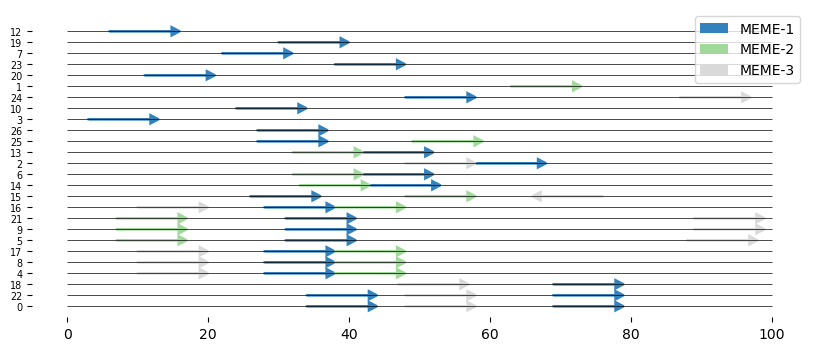

In [12]:
mast_file = MASTXMLFile('../data/data-1/meme/overdrive_virc2_variant_all/mast.xml')
mast_file.plot()

In [42]:
mast_df = mast_file.to_df()
mast_df[mast_df.motif_name.isin(['MEME-1', 'MEME-2', 'MEME-3'])].sort_values('motif_name')

# print(len(overdrive_df))
# overdrive_df.drop_duplicates('variant').seq.str.contains('TGTGA').sum()
# # len(mast_df['id'].unique())

,id,motif_idx,start,stop,motif_length,seq_length,p_value,strand,motif_name,seq,seq_upstream,seq_downstream
0,0,0,34,44,10,100,0.000005,+,MEME-1,GTATGTTTGT,TAGAATATTT,AAGAGCGTGA
51,19,0,30,40,10,100,0.000087,+,MEME-1,GTTTTTCTGT,TTCTGCATTT,TAACATGTTA
27,16,0,28,38,10,100,0.000025,+,MEME-1,GTGTGTTTGT,AAATCCCTGT,TTGATTGTTT
29,15,0,26,36,10,100,0.000008,+,MEME-1,GTTCGTTCGT,TTGTTCGCGT,GCATTAATCT
33,14,0,43,53,10,100,0.000001,+,MEME-1,GTTCGTTTGT,TTGTTTGTTC,AAAAATATTT
35,6,0,42,52,10,100,0.000012,+,MEME-1,ATTTGTTTGT,TTGATTGTTG,AACTTGTGTT
37,2,0,58,68,10,100,0.000099,+,MEME-1,GTTTATCCGT,GCGTGAAAAG,TCGTCCAT
39,13,0,42,52,10,100,0.000012,+,MEME-1,ATTTGTTTGT,TTGATTGTTG,AACTTGTGCG
40,25,0,27,37,10,100,0.000008,+,MEME-1,GTTCGTTCGT,TTGTTCGCGT,GCGTTAATCT
42,26,0,27,37,10,100,0.000003,+,MEME-1,GTACGTTTGT,GAATAGTATT,AAAAAGATTC


In [17]:
mast_df = mast_file.to_df()
mast_df = mast_df[mast_df.motif_name == 'MEME-1'].copy()
mast_df = mast_df.sort_values('p_value')
mast_df = mast_df.drop_duplicates('id')
mast_df.index = [f'meme1_{variant}' for variant in mast_df['id']]
# mast_df['seq'] = [row.seq_upstream + row.seq + row.seq_downstream for row in mast_df.itertuples()]
FASTAFile(df=mast_df).write('../data/data-1/meme1.fn')

! /home/prichter/muscle5.1.linux_intel64 -align ../data/data-1/meme1.fn -output ../data/data-1/meme1.afn


muscle 5.1.linux64 [12f0e2]  32.5Gb RAM, 16 cores
Built Jan 13 2022 23:17:13
(C) Copyright 2004-2021 Robert C. Edgar.
https://drive5.com

Input: 25 seqs, avg length 10, max 10

00:00 4.0Mb  CPU has 16 cores, running 16 threads
00:00 1.1Gb   100.0% Calc posteriors
00:00 1.1Gb   100.0% Consistency (1/2)
00:00 1.1Gb   100.0% Consistency (2/2)
00:00 1.1Gb   100.0% UPGMA5           
00:00 1.1Gb   100.0% Refining


In [16]:
# How should I go about comparing the similarity of the VirC1 alleles to the putative cis-regulatory elements?

# Some of the VirC1 sequences seem to be partial. However, based on the MSA, it seems as though the aligned region
# contains the DNA binding domains. 

variant_to_virc1_variant_map = overdrive_df.drop_duplicates('variant').set_index('variant').virc1_variant.to_dict()
variant_to_virc2_variant_map = overdrive_df.drop_duplicates('variant').set_index('variant').virc2_variant.to_dict()

virc1_msa_df = FASTAFile(path='../data/data-1/virc1.afa').to_df()
virc1_msa_df['variant'] = [int(id_.split('_')[-1]) for id_ in virc1_msa_df.index]

virc2_msa_df = FASTAFile(path='../data/data-1/virc2.afa').to_df()
virc2_msa_df['variant'] = [int(id_.split('_')[-1]) for id_ in virc2_msa_df.index]


meme1_msa_df = FASTAFile(path='../data/data-1/meme1.afn').to_df()
meme1_msa_df['variant'] = [int(id_.split('_')[-1]) for id_ in meme1_msa_df.index]
meme1_msa_df['virc1_variant'] = meme1_msa_df.variant.map(variant_to_virc1_variant_map)
meme1_msa_df['virc2_variant'] = meme1_msa_df.variant.map(variant_to_virc2_variant_map)

paired_msa_df = meme1_msa_df.copy()
paired_msa_df['virc1_seq'] = paired_msa_df.virc1_variant.map(virc1_msa_df.set_index('variant').seq)
paired_msa_df['virc2_seq'] = paired_msa_df.virc2_variant.map(virc2_msa_df.set_index('variant').seq)



In [ ]:
# It doesn't make any sense to me that VirC1 specifically recognizes overdrive, as it does not have a designated DNA binding domain. 
# It is in the ParA family of ATPases. ParA exhibits non-specific DNA binding, but needs a helper protein (ParB) with a helix-turn-helix
# domain to specifically recognize the parS sequences. This seems like it should be analagous to VirC2. 

walker_a_motif = r'G....GK[TS]'
deviant_walker_a_motif = r'.KGG..K[T/S]'
seq = overdrive_df.virc1_seq.iloc[0]
print(re.findall(deviant_walker_a_motif, seq, flags=re.DOTALL))
re.search(deviant_walker_a_motif, seq)

['FKGGAGKT']


<re.Match object; span=(8, 16), match='FKGGAGKT'>

In [ ]:
# cmap = LinearSegmentedColormap.from_list('palette', ['lightgray', 'indianred'])
# h = mutual_information(paired_msa_df.rename(columns={'seq':'seq_a', 'virc1_seq':'seq_b'}))
# sns.heatmap(h, cmap=cmap)

PKKLQVFLSAR
SVLVQTSRMFP


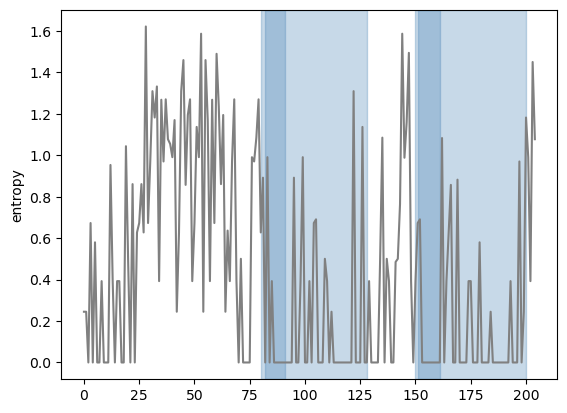

In [ ]:
def figure(msa_df, region=(0, -1), alphabet:dict=None):

    fig, ax = plt.subplots()

    beta_sheet_start_1 = 80
    beta_sheet_stop_1 = 91
    beta_sheet_start_2 = 150
    beta_sheet_stop_2 = 161

    ax.axvspan(xmin=82, xmax=128, color='steelblue', alpha=0.3)
    ax.axvspan(xmin=151, xmax=200, color='steelblue', alpha=0.3)

    ax.axvspan(xmin=beta_sheet_start_1, xmax=beta_sheet_stop_1, color='steelblue', alpha=0.3)
    ax.axvspan(xmin=beta_sheet_start_2, xmax=beta_sheet_stop_2, color='steelblue', alpha=0.3)

    msa_df = msa_df.copy()
    if alphabet is not None:
        msa_df['seq'] = msa_df.seq.apply(lambda seq : reduce(seq, alphabet))
        
    alignment = np.array([list(seq[region[0]:region[1]]) for seq in msa_df.seq])
    print(''.join(alignment[0, beta_sheet_start_1:beta_sheet_stop_1]))
    print(''.join(alignment[0, beta_sheet_start_2:beta_sheet_stop_2]))
    # print(alignment[:, 154].tolist())

    entropies = list()
    positions = np.arange(alignment.shape[-1])
    x_labels = []
    for i in range(alignment.shape[-1]):
        residues = alignment.T[i]
        probabilities = [(residues == residue).mean() for residue in np.unique(residues)]
        x_labels.append(np.unique(residues)[np.argmax(probabilities)])
        entropy = -sum([p * np.log(p) for p in probabilities])
        entropies.append(entropy)

    # ax.set_xticks(np.arange(len(positions)), labels=x_labels)
    ax.set_ylabel('entropy')
    ax.plot(positions, entropies, color='gray')


    plt.show()

figure(virc2_msa_df, region=(0, -1), alphabet=None)

# Mutations that abolish DNA binding. 
# Arg 117
# Ser 155
# Arg 179

# Although the VirC2 DNA binding sites are highly conserved (especially using the Dayhoff reduced alphabet), 
# there is some variability, which could map to differences in motif recognition. 


array(['GTATGTCTGT', 'ATTCGTTTGT', 'GTACGTCTGT', 'GTGTGTTTGT',
       'GTTTTTCTGT', 'GTTTGTTTGT', 'GTTCGTTTGT', 'ATTTGTTTGT',
       'GTTCGTTCGT', 'GTTCATTTGT', 'GTTTATCCGT', 'GTATGTTTGT',
       'GTACGTTTGT', 'ATTAGTTTGT'], dtype=object)

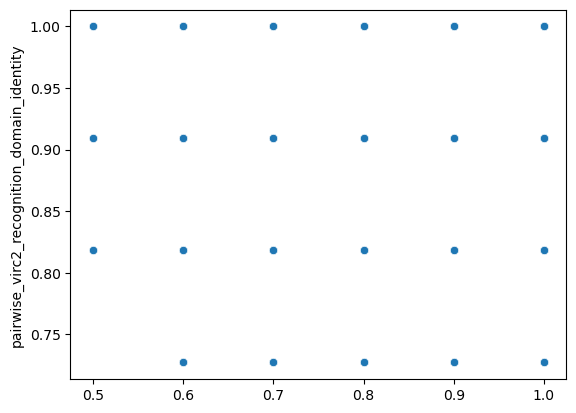

In [40]:
def get_pairwise_identity(seq_a, seq_b):
    seq_a, seq_b = np.array(list(seq_a)), np.array(list(seq_b))
    return np.mean(seq_a == seq_b)

def get_residues(seq, idxs):
    seq = np.array(list(seq))
    return ''.join([seq[i] for i in idxs])

beta_sheet_start_1 = 80
beta_sheet_stop_1 = 91
beta_sheet_start_2 = 150
beta_sheet_stop_2 = 161

paired_msa_df = meme1_msa_df.copy()
paired_msa_df['virc2_seq'] = paired_msa_df.virc2_variant.map(virc2_msa_df.set_index('variant').seq)
# paired_msa_df['seq'] = paired_msa_df.seq.str.slice(5, 9)
paired_msa_df['virc2_seq'] = paired_msa_df.virc2_seq.apply(lambda seq : seq[beta_sheet_start_2:beta_sheet_stop_2])

x, y = list(), list()

for row_a in paired_msa_df.itertuples():
    for row_b in paired_msa_df.itertuples():
        x.append(get_pairwise_identity(row_a.seq, row_b.seq))
        y.append(get_pairwise_identity(row_a.virc2_seq, row_b.virc2_seq))

fig, ax = plt.subplots()
sns.scatterplot(x=x, y=y)
ax.set_ylabel('pairwise_motif_identity')
ax.set_ylabel('pairwise_virc2_recognition_domain_identity')
paired_msa_df.virc2_seq.unique()
paired_msa_df.seq.unique()
# paired_msa_df.seq.str.slice(0, 7).nunique()

In [ ]:
# mast_df = list()
# for virc1_variant in sorted(overdrive_df.virc1_variant.unique().astype(int)):
#     path = f'../data/data-1/meme/overdrive_virc1_variant_{virc1_variant}/mast.xml'
#     if os.path.exists(path):
#         print(f'VirC variant {virc1_variant}')
#         mast_file = MASTXMLFile(path)
#         mast_df.append(mast_file.to_df().assign(virc1_variant=virc1_variant))
#         mast_file.plot(max_p_value=None)
# mast_df = pd.concat(mast_df)
# mast_df['seq'] = [str(Seq(row.seq).reverse_complement()) if (row.strand == '-') else row.seq for row in mast_df.itertuples()]

# overdrive_motifs = dict()
# overdrive_motifs[0] = 'MEME-1'
# overdrive_motifs[1] = 'MEME-1'
# overdrive_motifs[2] = 'MEME-5'
# overdrive_motifs[4] = 'MEME-3'
# overdrive_motifs[5] = 'MEME-1' # or MEME-2
# overdrive_motifs[6] = 'MEME-1'
# overdrive_motifs[7] = 'MEME-1'
# overdrive_motifs[9] = 'MEME-5'

# for virc1_variant, df in mast_df.groupby('virc1_variant'):
#     if virc1_variant in overdrive_motifs:
#         motifs = np.unique(df[df.motif_name == overdrive_motifs[virc1_variant]].sort_values('start').seq.values.tolist())
#         overdrive_motifs[virc1_variant] = motifs


In [ ]:
# What are the actual differences between VirC1 alleles?
virc1_df = virc1_df.sort_values('group')
groups = overdrive_df.virc1_group.unique()
alignment = [list(seq) for seq in virc1_df.groupby('group').dna_binding_domain.first()]
alignment = np.array(alignment)

figure_df = pd.DataFrame(alignment, index=groups)

# It seems likely that more similar VirC1 alleles have more similar putative binding sites. 

p = np.empty(shape=alignment.shape)
for i in range(figure_df.shape[0]):
    for j in range(figure_df.shape[1]):
        p[i, j] = np.mean(alignment[i, j] == alignment[:, j])
# residue_counts = [len(np.unique(col)) for col in alignment.T]
figure_df = pd.DataFrame(p, index=figure_df.index, columns=figure_df.columns)

fig, ax = plt.subplots()

cmap = LinearSegmentedColormap.from_list('probability', ['indianred', 'lightgray', 'steelblue'])
# sns.lineplot(x=np.arange(len(alignment.T)), y=residue_counts)
sns.heatmap(figure_df, cmap=cmap)
ax.set_ylabel('VirC1 allele')
ax.set_xlabel('position')

for i in figure_df.index:
    motif = overdrive_motifs[i]
    ax.text(i, 120, motif)
plt.show()



NameError: name 'virc1_df' is not defined

In [ ]:

def run_meme(protein:str='virc1', group:int=3, data_dir:str='../data/data-1', motif_length:int=10, n_motifs:int=5):
    group = int(group)
    meme_input_path = f'{data_dir}/overdrive_{protein}_group_{group}.fn'
    output_dir = f'{data_dir}/meme/overdrive_{protein}_group_{group}'

    cmd = f'meme {meme_input_path} -dna -oc . -nostatus -time 14400 -mod zoops -nmotifs {n_motifs} -minw {motif_length} -maxw {motif_length} -objfun classic -revcomp -markov_order 1 -oc {output_dir}'
    subprocess.run(cmd, shell=True, check=True)

    mast_input_path = os.path.join(output_dir, 'meme.xml')
    cmd = f'mast {mast_input_path} {meme_input_path} -oc {output_dir} -nostatus'
    subprocess.run(cmd, shell=True, check=True)
    print(f'run_meme: Completed motif detection for {meme_input_path}.')

# for protein in ['virc1', 'virc2']:
#     for group in overdrive_df[f'{protein}_group'].unique():
#         run_meme(protein=protein, group=group)

In [ ]:
core = 'ATGTTTGTTT'
core = 'TATGTTTGTTTG'

def get_core_pattern(edit_distance:int=2, core:str=core):
    if edit_distance == 0:
        return core 
    
    core = list(core)
    pattern = list()
    for idxs in itertools.combinations(np.arange(len(core)), edit_distance):
        core_ = core.copy()
        for i in idxs:
            core_[i] = '.'
        pattern.append(''.join(core_))
    print(f'get_core_pattern: Searching for {4 ** edit_distance * len(pattern)} sequences.')
    return '|'.join(pattern)

core = get_core_pattern(edit_distance=1)
mask = overdrive_df.seq.apply(lambda seq : re.search(core, seq) is not None)
overdrive_df[mask].virc1_group.value_counts()

# get_core_pattern()

get_core_pattern: Searching for 48 sequences.


virc1_group
4    16
1     2
0     2
2     1
Name: count, dtype: int64

In [ ]:
overdrive_df.virc2_variant.value_counts() #.sum()
overdrive_df.drop_duplicates('seq').virc1_group.value_counts()

virc1_group
4    4
1    4
3    3
0    3
7    3
2    2
6    2
Name: count, dtype: int64

In [ ]:
df = pd.read_csv('../data/data-1/meme/overdrive_fimo_core_p_0.1.tsv', sep='\t', comment='#')
df = df.sort_values('p-value')
df.sequence_name.nunique() #.matched_sequence.value_counts()
df.drop_duplicates('sequence_name').matched_sequence.value_counts()

matched_sequence
TTCTTTGTTT    17
TTGCCTGATT    12
TTGTTTGTGT     8
ATGTTTGTTT     6
TTCTTTGTTC     6
              ..
GCGTTCGATT     1
ATAATCGTAT     1
ATGTCGATTC     1
ATTTCTGCCT     1
CTATTTGATC     1
Name: count, Length: 76, dtype: int64